In [55]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.preprocessing import fix_data_types, merge_geolocation, clean_data, add_features

# Ensure path for src imports
sys.path.append(os.path.abspath(".."))

# Ecommerce Fraud Detection: Exploratory Data Analysis (EDA)

This notebook performs data cleaning, preprocessing, feature engineering, and EDA for the fraud detection project.

In [56]:
fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

## 1. Data Loading

Load the raw fraud and IP datasets to begin analysis.

## 2. Data Type Corrections

Convert IP addresses to integers and dates to datetime objects to prevent precision errors and enable time-based operations.

In [57]:
fraud_df, ip_df = fix_data_types(fraud_df, ip_df)

## 3. Geolocation Merge

Merge fraud data with IP-to-country mappings using approximate matching to add country information for geographic analysis.

In [58]:
merged_df = merge_geolocation(fraud_df, ip_df)

In [59]:
print("Merge Complete. Sample:")

print(merged_df[["user_id", "country", "class"]].head(10))

Merge Complete. Sample:
     user_id    country  class
634   247547  Australia      0
635   220737   Thailand      0
636   390400      China      0
637    69592      China      0
638   174987   Thailand      0
639    23204      China      0
640   155230   Thailand      0
641   199369      Japan      0
642   236894      Japan      0
643   379446      Japan      0


## 4. Final Cleaning

Handle missing values and remove duplicates to ensure data integrity.

In [60]:
merged_df = clean_data(merged_df)

In [61]:
# Final Shape Check
print(f"Final Cleaned Data Shape: {merged_df.shape}")


Final Cleaned Data Shape: (129146, 14)


## 5. Feature Engineering

Add temporal features to capture patterns in user behavior, such as time since signup, hour of day, and day of week.

In [62]:
merged_df = add_features(merged_df)

print("Feature engineering complete.")
print(merged_df[['time_since_signup', 'hour_of_day', 'day_of_week']].head())

Feature engineering complete.
     time_since_signup  hour_of_day  day_of_week
634          3632215.0            3            6
635          1231637.0           20            2
636          1997534.0           23            5
637          7640897.0           16            5
638         10249579.0            4            1


## 6. EDA Visualizations

Generate advanced visualizations to uncover insights into fraud patterns.

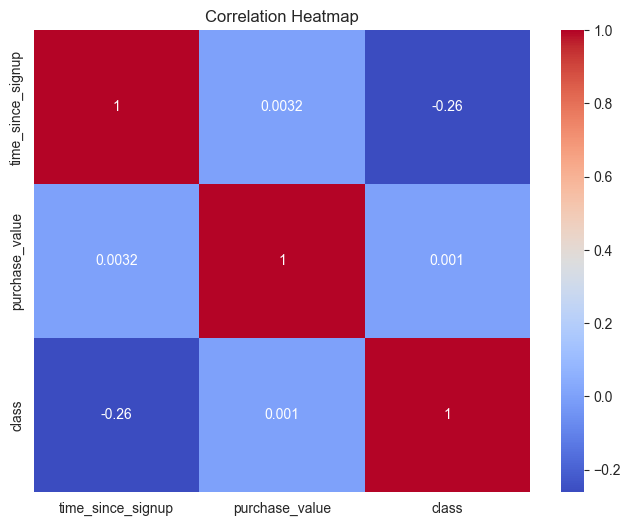

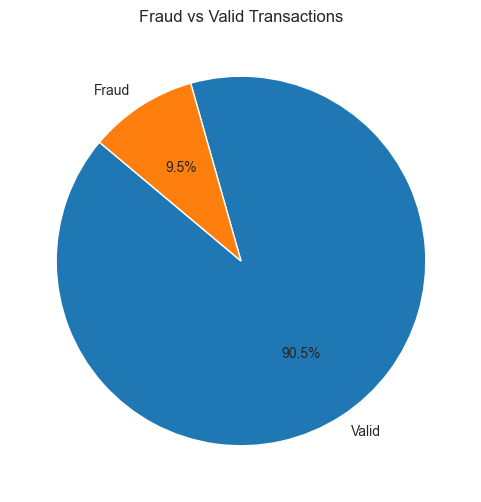

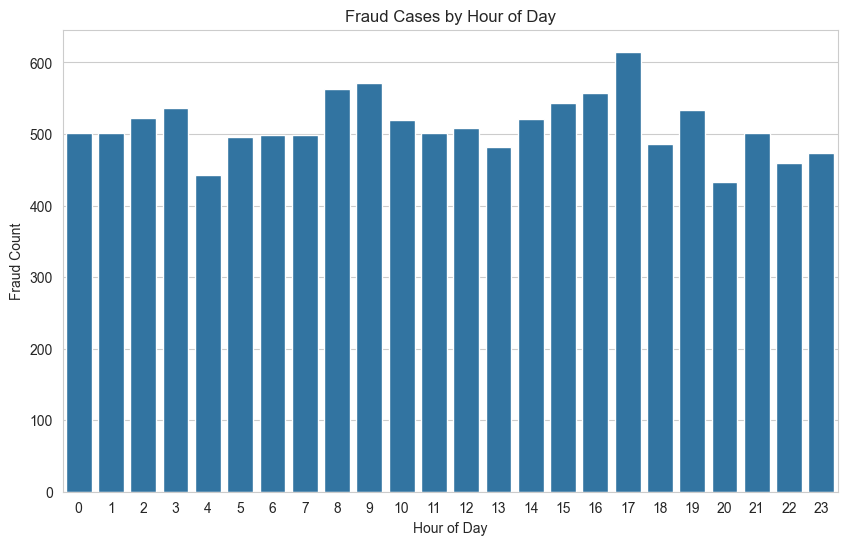

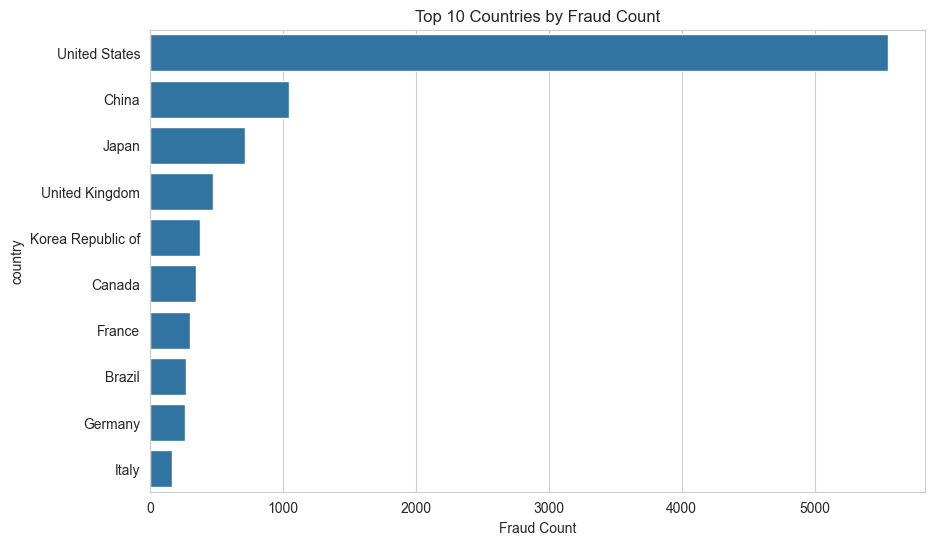

In [47]:
sns.set_style('whitegrid')

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[['time_since_signup', 'purchase_value', 'class']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('../images/correlation_heatmap.png')
plt.show()

# Fraud vs Valid Distribution (Pie Chart)
class_counts = merged_df['class'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Valid', 'Fraud'], autopct='%1.1f%%', startangle=140)
plt.title('Fraud vs Valid Transactions')
plt.savefig('../images/fraud_distribution_pie.png')
plt.show()

# The Bot Hour: Fraud by Hour
fraud_by_hour = merged_df[merged_df['class'] == 1]['hour_of_day'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values)
plt.title('Fraud Cases by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Count')
plt.savefig('../images/fraud_by_hour.png')
plt.show()

# Country Risk: Top 10 Countries
fraud_by_country = merged_df[merged_df['class'] == 1]['country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_country.values, y=fraud_by_country.index)
plt.title('Top 10 Countries by Fraud Count')
plt.xlabel('Fraud Count')
plt.savefig('../images/country_risk.png')
plt.show()

## 7. Creditcard Data Analysis

Load and analyze the creditcard.csv dataset for missing values, duplicates, and EDA.

In [48]:
creditcard_df = pd.read_csv("../data/raw/creditcard.csv")
print(f"Creditcard Data Shape: {creditcard_df.shape}")
print(f"Missing Values: {creditcard_df.isnull().sum().sum()}")
print(f"Duplicates: {creditcard_df.duplicated().sum()}")
creditcard_df = creditcard_df.drop_duplicates()  # Remove duplicates
print(f"After Cleaning Shape: {creditcard_df.shape}")

Creditcard Data Shape: (284807, 31)
Missing Values: 0
Duplicates: 1081
After Cleaning Shape: (283726, 31)


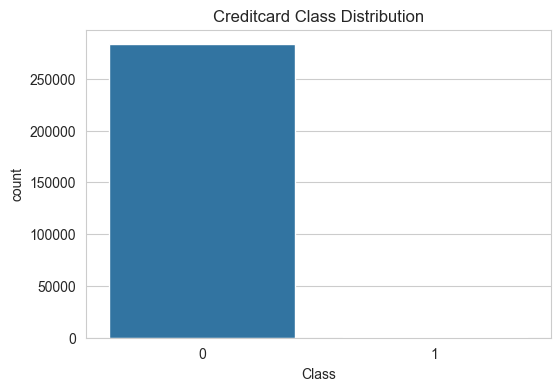

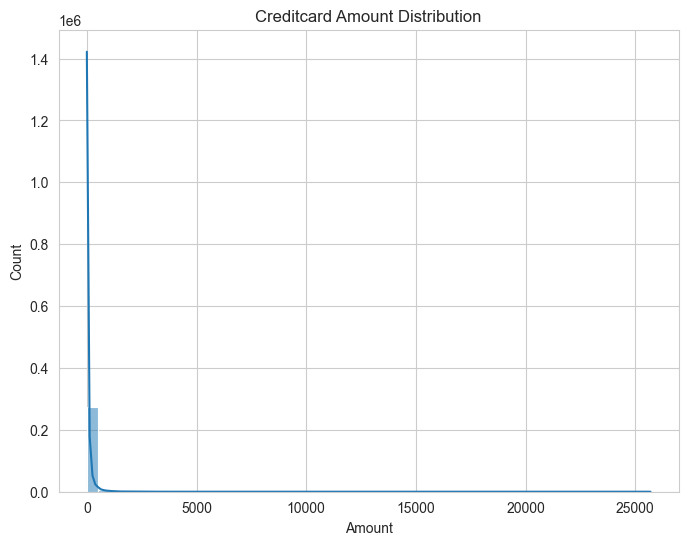

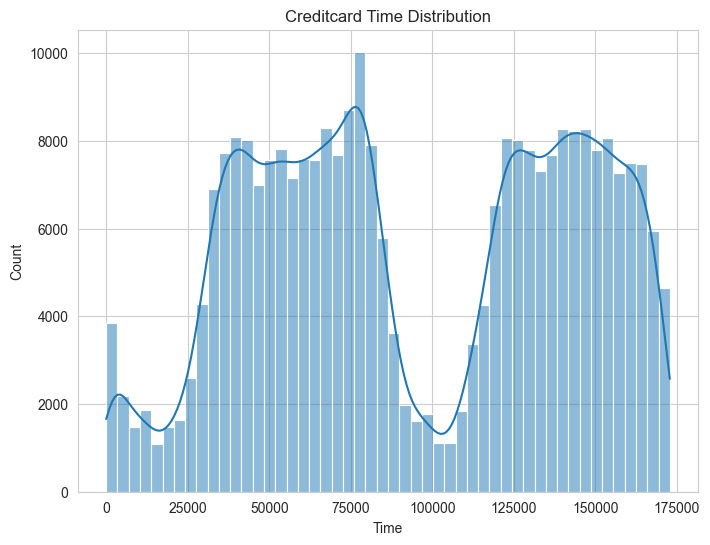

In [49]:
sns.set_style('whitegrid')

# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=creditcard_df)
plt.title('Creditcard Class Distribution')
plt.savefig('../images/creditcard_class_distribution.png')
plt.show()

# Amount Distribution
plt.figure(figsize=(8, 6))
sns.histplot(creditcard_df['Amount'], bins=50, kde=True)
plt.title('Creditcard Amount Distribution')
plt.savefig('../images/creditcard_amount_distribution.png')
plt.show()

# Time Distribution
plt.figure(figsize=(8, 6))
sns.histplot(creditcard_df['Time'], bins=50, kde=True)
plt.title('Creditcard Time Distribution')
plt.savefig('../images/creditcard_time_distribution.png')
plt.show()

## 8. Class Imbalance Handling with Oversampling

Split data, apply oversampling to training set only, and document class distributions.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Prepare X and y (using merged_df from Fraud_Data)
X = merged_df.drop('class', axis=1).select_dtypes(include=[float, int])  # Numeric features only for simplicity
y = merged_df['class']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Class distribution before resampling:")
print(y_train.value_counts())

# Apply simple oversampling to training data only (to balance classes)
# Combine X_train and y_train
train_data = X_train.copy()
train_data['class'] = y_train

# Separate majority and minority classes
majority = train_data[train_data['class'] == 0]
minority = train_data[train_data['class'] == 1]

# Oversample minority class
minority_oversampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)

# Combine majority and oversampled minority
train_oversampled = pd.concat([majority, minority_oversampled])

# Split back
X_train_sm = train_oversampled.drop('class', axis=1)
y_train_sm = train_oversampled['class']

print("Class distribution after oversampling:")
print(y_train_sm.value_counts())

# Note: X_test and y_test remain untouched

Class distribution before resampling:
class
0    93502
1     9814
Name: count, dtype: int64
Class distribution after oversampling:
class
0    93502
1    93502
Name: count, dtype: int64
